# Kernel Density Analysis

This document includes Python codes that conduct kernel density analysis on water quality parameters, including Total Nitrogen, Salinity, Dissolved Oxygen, Turbidity, and Secchi Depth.

The analysis is conducted in Charlotte Harbor, Estero Bay, Big Bend, Biscayne Bay, Matlacha Pass, and Guana Tolomato.

Tasks:  

• Create Kernel Density Maps for 1) continuous data points, 2) discrete data points, and 3) continuous + discrete data points.  
• Create Kernel Density Maps for all five managed areas and five parameters. So in total, there will be 75 maps.

* [1.Data Preprocess](#preprocessing)
    * [1.1 Preset Parameters](#preset)
    * [1.2 Read and Explore Dataset](#explore)
* [2. Create_Kernel_Density_Map](#plot_kernel_density_map)
* [3. Discrete Result](#reg_result_dis)
    * [3.1 Charlotte Harbor](#reg_result_dis_ch)
    * [3.2 Estero Bay](#reg_result_dis_eb)
    * [3.3 Big Bend](#reg_result_dis_bb)
    * [3.4 Biscayne Bay Aquatic Preserve](#reg_result_dis_bbap)
    * [3.5 Guana Tolomato Matanzas NERR](#reg_result_dis_gt)
* [4. Continuous Result](#reg_result_con)
    * [4.1 Charlotte Harbor](#reg_result_con_ch)
    * [4.2 Estero Bay](#reg_result_con_eb)
    * [4.3 Big Bend](#reg_result_con_bb)
    * [4.4 Biscayne Bay Aquatic Preserve](#reg_result_con_bbap)
    * [4.5 Guana Tolomato Matanzas NERR](#reg_result_con_gt)
* [5. Combined Result](#reg_result_dis_con)
    * [5.1 Charlotte Harbor](#reg_result_dis_con_ch)
    * [5.2 Estero Bay](#reg_result_dis_con_eb)
    * [5.3 Big Bend](#reg_result_dis_con_bb)
    * [5.4 Biscayne Bay Aquatic Preserve](#reg_result_dis_con_bbap)
    * [5.5 Guana Tolomato Matanzas NERR](#reg_result_dis_con_gt)
* [6. Save and Plot Kernel Density Results](#reg_KDE_analysis)
    * [6.1 Discrete_TIF](#reg_result_dis_KDE_analysis)
        * [6.1.1 Charlotte Harbor](#reg_result_dis_ch_tif)
        * [6.1.2 Estero Bay](#reg_result_dis_eb_tif)
        * [6.1.3 Big Bend](#reg_result_dis_bb_tif)
        * [6.1.4 Biscayne Bay Aquatic Preserve](#reg_result_dis_bbap_tif)
        * [6.1.5 Guana Tolomato Matanzas NERR](#reg_result_dis_gt_tif)
    * [6.2 Continuous_TIF](#reg_result_con_KDE_analysis)
        * [6.2.1 Charlotte Harbor](#reg_result_con_ch_tif)
        * [6.2.2 Estero Bay](#reg_result_con_eb_tif)
        * [6.2.3 Big Bend](#reg_result_con_bb_tif)
        * [6.2.4 Biscayne Bay Aquatic Preserve](#reg_result_con_bbap_tif)
        * [6.2.5 Guana Tolomato Matanzas NERR](#reg_result_con_gt_tif)
    * [6.3 All_TIF](#reg_result_all_KDE_analysis)
        * [6.3.1 Charlotte Harbor](#reg_result_all_ch_tif)
        * [6.3.2 Estero Bay](#reg_result_all_eb_tif)
        * [6.3.3 Big Bend](#reg_result_all_bb_tif)
        * [6.3.4 Biscayne Bay Aquatic Preserve](#reg_result_all_bbap_tif)
        * [6.3.5 Guana Tolomato Matanzas NERR](#reg_result_all_gt_tif)

In [4]:
import pandas as pd


In [2]:
# Import all necessary packages
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as cx
import numpy as np
import scipy.stats as stats
import rasterio
from rasterio.transform import from_origin
import os
import matplotlib.gridspec as gridspec
import math
from shapely.geometry import Point
from rasterio.transform import Affine
import matplotlib.image as mpimg
from rasterio.plot import show
import rasterio.plot as rp
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable
from shapely.geometry import box
from rasterio.mask import mask
from matplotlib.colors import ListedColormap
from shapely.geometry import mapping

import sys
sys.path.append('..')
import misc.gap_analysis

ModuleNotFoundError: No module named 'seaborn'

# 1. Data Preprocessing <a class="anchor" id="preprocessing"></a>
Define the water quality parameter folders

In [2]:
path = '../../'
dfDis_orig = pd.read_csv(path + r"discrete_0214.csv", low_memory=False)
dfCon_orig = pd.read_csv(path + r"continuous_0214.csv", low_memory=False)
dfAll_orig = pd.read_csv(path + r"all_0214.csv", low_memory=False)
dis_folder = path + r"Correlation_Analysis/KDE_update/KDE_Dis_Results"
con_folder = path + r"Correlation_Analysis/KDE_update/KDE_Con_Results"
all_folder = path + r"Correlation_Analysis/KDE_update/KDE_All_Results"
gis_path = path+'GIS_data/'
boundary = gpd.read_file(gis_path + r"managed_area_boundary/ORCP_Managed_Areas_Oct2021.shp")

In [3]:
dfDis_orig = dfDis_orig[(dfDis_orig['Year'] >= 2015) & (dfDis_orig['Year'] <= 2019)]
dfCon_orig = dfCon_orig[(dfCon_orig['Year'] >= 2015) & (dfCon_orig['Year'] <= 2019)]
dfAll_orig = dfAll_orig[(dfAll_orig['Year'] >= 2015) & (dfAll_orig['Year'] <= 2019)]

In [4]:
boundary = boundary.to_crs('epsg:3086')

In [5]:
dfDis_orig['timestamp'] = pd.to_datetime(dfDis_orig['timestamp'])
dfCon_orig['timestamp'] = pd.to_datetime(dfCon_orig['timestamp'])
dfAll_orig['timestamp'] = pd.to_datetime(dfAll_orig['timestamp'])

In [48]:
dfAll_orig['ManagedAreaName'].unique()

array(['Guana Tolomato Matanzas National Estuarine Research Reserve',
       'Big Bend Seagrasses Aquatic Preserve',
       'Gasparilla Sound-Charlotte Harbor Aquatic Preserve',
       'Pine Island Sound Aquatic Preserve', 'Cape Haze Aquatic Preserve',
       'Matlacha Pass Aquatic Preserve', 'Lemon Bay Aquatic Preserve',
       'Biscayne Bay Aquatic Preserve', 'Estero Bay Aquatic Preserve'],
      dtype=object)

In [19]:
dfCon_orig[(dfCon_orig['timestamp'] > '8/27/20') & 
           (dfCon_orig['timestamp'] < '12/24/2019')& 
           (dfCon_orig['ManagedAreaName'] == 'Estero Bay Aquatic Preserve')]['ParameterName'].unique()

array(['Dissolved Oxygen', 'Salinity', 'Turbidity'], dtype=object)

In [41]:
dfCon_orig.timestamp.max()

Timestamp('2019-12-31 18:45:00')

# 1 Check original data  <a class="anchor" id="preset"></a>

In [ ]:
col_ls = ['RowID','ParameterName','ParameterUnits','ProgramLocationID','ActivityType','ManagedAreaName',
               'SampleDate','Year','Month','ResultValue','ValueQualifier','Latitude_DD','Longitude_DD']
para_ls = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"]

dfDis_orig0 = pd.read_csv(path + r"OEAT_Discrete-2023-Jan-23.csv", low_memory=False)
dfCon_orig00 = pd.read_csv(path + r"OEAT_Continuous_1-2023-Jan-23.csv", low_memory=False)
dfCon_orig01 = pd.read_csv(path + r"OEAT_Continuous_2-2023-Jan-23.csv", low_memory=False)

In [ ]:
path = '../../'

dfCon_orig = pd.read_csv(path + r"OEAT_Continuous-2022-Nov-04.csv", low_memory=False)

In [ ]:
dfCon_orig['ParameterName'].unique()

In [25]:
col_ls = ['RowID','ParameterName','ParameterUnits','ProgramLocationID','ActivityType','ManagedAreaName',
               'SampleDate','Year','Month','ResultValue','ValueQualifier','Latitude_DD','Longitude_DD']
para_ls = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"]

dfDis_orig0 = dfDis_orig0[col_ls]
dfCon_orig00 = dfCon_orig00[col_ls]
dfCon_orig01 = dfCon_orig01[col_ls]



NameError: name 'df' is not defined

In [27]:
dfDis_orig0 = dfDis_orig0.loc[dfDis_orig0["ParameterName"].isin(para_ls)]
dfCon_orig00 = dfCon_orig00.loc[dfCon_orig00["ParameterName"].isin(para_ls)]
dfCon_orig01 = dfCon_orig01.loc[dfCon_orig01["ParameterName"].isin(para_ls)]

dfCon_orig0  = pd.concat([dfCon_orig00,dfCon_orig01],ignore_index=True)

In [33]:
dfDis_orig0['ParameterName'].unique()

array(['Total Phosphorus', 'Chlorophyll a uncorrected for pheophytin',
       'Dissolved Oxygen', 'Dissolved Oxygen Saturation',
       'NO2+3 Filtered', 'pH', 'Salinity', 'Secchi Depth',
       'Specific Conductivity', 'Total Kjeldahl Nitrogen TKN',
       'Water Temperature', 'Turbidity', 'Light Extinction Coefficient',
       'NH4 Filtered', 'PO4 Filtered', 'Total Suspended Solids, TSS',
       'Colored dissolved organic matter, CDOM',
       'Chlorophyll a corrected for pheophytin', 'Total Nitrogen',
       'Ammonia- Un-ionized (NH3)', 'Nitrate (N)', 'Nitrite (N)',
       'Nitrogen, organic'], dtype=object)

In [ ]:
dfDis_orig0["timestamp"]=  pd.to_datetime(dfDis_orig0['SampleDate'])
dfCon_orig0["timestamp"]=  pd.to_datetime(dfCon_orig0['SampleDate'])

dfDis_orig0 = dfDis_orig0[(dfDis_orig0['timestamp'] > '01/01/2001')]
dfDis_orig0_mean = dfDis_orig0.groupby(['Latitude_DD','Longitude_DD',"ParameterName","ManagedAreaName"])["ResultValue"].agg("mean").reset_index()

dfCon_orig0 = dfCon_orig0[(dfCon_orig0['timestamp'] > '01/01/2001')]
dfCon_orig0_mean = dfCon_orig0.groupby(['Latitude_DD','Longitude_DD',"ParameterName","ManagedAreaName"])["ResultValue"].agg("mean").reset_index()

# Concatenate dry and wet dataframes
df_mean = pd.concat([dfDis_orig0_mean,dfCon_orig0_mean],ignore_index=True)


In [9]:
area_shortnames = {
    'Gasparilla Sound-Charlotte Harbor Aquatic Preserve': 'Gasparilla Sound-Charlotte Harbor',
    'Estero Bay Aquatic Preserve': 'Estero Bay',
    'Big Bend Seagrasses Aquatic Preserve': 'Big Bend Seagrasses',
    'Biscayne Bay Aquatic Preserve': 'Biscayne Bay',
    'Matlacha Pass Aquatic Preserve': 'Matlacha Pass',
    'Guana Tolomato Matanzas National Estuarine Research Reserve' : 'Guana Tolomato Matanzas NERR'
}

param_shortnames = {
    'Salinity': 'SA',
    'Total Nitrogen': 'TN',
    'Dissolved Oxygen': 'DO',
    'Turbidity':'TB',
    'Secchi Depth':'SD'
}

# 1.2 Read and Explore the Dataset <a class="anchor" id="explore"></a>

In [10]:
# Read discrete data
dfDis_orig['ParameterName'].value_counts()

Dissolved Oxygen    45454
Salinity            42889
Secchi Depth        20172
Turbidity            7962
Total Nitrogen       7043
Name: ParameterName, dtype: int64

In [11]:
dfDis_orig['ManagedAreaName'].value_counts()

Big Bend Seagrasses Aquatic Preserve                           57611
Gasparilla Sound-Charlotte Harbor Aquatic Preserve             24715
Pine Island Sound Aquatic Preserve                             13333
Biscayne Bay Aquatic Preserve                                   7663
Cape Haze Aquatic Preserve                                      4807
Estero Bay Aquatic Preserve                                     4438
Guana Tolomato Matanzas National Estuarine Research Reserve     4201
Lemon Bay Aquatic Preserve                                      3564
Matlacha Pass Aquatic Preserve                                  3188
Name: ManagedAreaName, dtype: int64

In [12]:
dfDis_orig[dfDis_orig['ParameterName'] == 'Salinity'].groupby('ManagedAreaName')['ParameterName'].value_counts()

ManagedAreaName                                              ParameterName
Big Bend Seagrasses Aquatic Preserve                         Salinity         22229
Biscayne Bay Aquatic Preserve                                Salinity          2075
Cape Haze Aquatic Preserve                                   Salinity          1799
Estero Bay Aquatic Preserve                                  Salinity           301
Gasparilla Sound-Charlotte Harbor Aquatic Preserve           Salinity          8247
Guana Tolomato Matanzas National Estuarine Research Reserve  Salinity          1465
Lemon Bay Aquatic Preserve                                   Salinity          1240
Matlacha Pass Aquatic Preserve                               Salinity          1118
Pine Island Sound Aquatic Preserve                           Salinity          4415
Name: ParameterName, dtype: int64

Continuous data only has three water quality parameters: Salinity,Dissolved Oxygen, and Turbidity.

In [13]:
# Read continuous data
dfCon_orig['ParameterName'].value_counts()

Salinity            752699
Dissolved Oxygen    721753
Turbidity           629282
Name: ParameterName, dtype: int64

In [14]:
dfCon_orig['ManagedAreaName'].value_counts()

Guana Tolomato Matanzas National Estuarine Research Reserve    694583
Matlacha Pass Aquatic Preserve                                 623319
Estero Bay Aquatic Preserve                                    569663
Big Bend Seagrasses Aquatic Preserve                           118084
Biscayne Bay Aquatic Preserve                                   98085
Name: ManagedAreaName, dtype: int64

In [15]:
dfCon_orig[dfCon_orig['ParameterName'] == 'Salinity'].groupby('ManagedAreaName')['ParameterName'].value_counts()

ManagedAreaName                                              ParameterName
Big Bend Seagrasses Aquatic Preserve                         Salinity          44645
Biscayne Bay Aquatic Preserve                                Salinity          37064
Estero Bay Aquatic Preserve                                  Salinity         213468
Guana Tolomato Matanzas National Estuarine Research Reserve  Salinity         225959
Matlacha Pass Aquatic Preserve                               Salinity         231563
Name: ParameterName, dtype: int64

In [16]:
dfCon_orig[dfCon_orig['ParameterName'] == 'Dissolved Oxygen'].groupby('ManagedAreaName')['ParameterName'].value_counts()

ManagedAreaName                                              ParameterName   
Big Bend Seagrasses Aquatic Preserve                         Dissolved Oxygen     38431
Biscayne Bay Aquatic Preserve                                Dissolved Oxygen     27335
Estero Bay Aquatic Preserve                                  Dissolved Oxygen    202527
Guana Tolomato Matanzas National Estuarine Research Reserve  Dissolved Oxygen    234814
Matlacha Pass Aquatic Preserve                               Dissolved Oxygen    218646
Name: ParameterName, dtype: int64

In [17]:
dfCon_orig[dfCon_orig['ParameterName'] == 'Turbidity'].groupby('ManagedAreaName')['ParameterName'].value_counts()

ManagedAreaName                                              ParameterName
Big Bend Seagrasses Aquatic Preserve                         Turbidity         35008
Biscayne Bay Aquatic Preserve                                Turbidity         33686
Estero Bay Aquatic Preserve                                  Turbidity        153668
Guana Tolomato Matanzas National Estuarine Research Reserve  Turbidity        233810
Matlacha Pass Aquatic Preserve                               Turbidity        173110
Name: ParameterName, dtype: int64

In [18]:
# Read All data
dfAll_orig['ParameterName'].value_counts()

Salinity            795588
Dissolved Oxygen    767207
Turbidity           637244
Secchi Depth         20172
Total Nitrogen        7043
Name: ParameterName, dtype: int64

In [19]:
dfAll_orig['ManagedAreaName'].value_counts()

Guana Tolomato Matanzas National Estuarine Research Reserve    698784
Matlacha Pass Aquatic Preserve                                 626507
Estero Bay Aquatic Preserve                                    574101
Big Bend Seagrasses Aquatic Preserve                           175695
Biscayne Bay Aquatic Preserve                                  105748
Gasparilla Sound-Charlotte Harbor Aquatic Preserve              24715
Pine Island Sound Aquatic Preserve                              13333
Cape Haze Aquatic Preserve                                       4807
Lemon Bay Aquatic Preserve                                       3564
Name: ManagedAreaName, dtype: int64

In [20]:
# dfCon_orig[dfCon_orig['ParameterName'] == 'Salinity'].groupby('ManagedAreaName')['ParameterName'].value_counts()

# 2. Plot Kernel Density Map <a class="anchor" id="plot_kernel_density_map"></a>

Function to plot kernel density map.

In [21]:
def plot_kde_map(df, lat_col, lon_col, area_names, variables,boundary):
    # Preprocess input data
    df_filtered = df[df['ManagedAreaName'].isin(area_names) & df['ParameterName'].isin(variables)]
    
    gdf = gpd.GeoDataFrame(df_filtered,
                        geometry=[Point(x, y) for x, y in zip(df_filtered[lon_col], df_filtered[lat_col])],
                        crs=4326)
    gdf = gdf.to_crs('epsg:3086')

    grouped_gdf = gdf.groupby(['ManagedAreaName', 'ParameterName'])

    # Calculate the total number of subplots
    total_plots = len(grouped_gdf)

    rows = math.ceil(total_plots / 3)
    cols = min(total_plots, 3)
    fig, axes = plt.subplots(rows, cols, figsize=(30, 25), squeeze=False)

    plot_index = 0
    
    for (area_name, variable), group in grouped_gdf:
        row, col = divmod(plot_index, cols)
        ax = axes[row, col]
        kdeplot = sns.kdeplot(x=group.geometry.x, y=group.geometry.y, n_levels=30, fill=True, cmap='YlOrRd', ax=ax, bw_method='scott')
        # Add point locations to the kernel density map
        #group.plot(ax=ax, color='black', markersize=0.1)
        ax.set_title(f"KDE - {area_shortnames[area_name]} - {param_shortnames[variable]}", fontdict={'fontsize': 25, 'fontweight': 'bold'})
        ax.set_box_aspect(1)
        cx.add_basemap(ax=ax, source=cx.providers.Stamen.TonerLite, crs=gdf.crs)
        
        # Create colorbar that matches the height of the plot
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)

        # Create a ScalarMappable with the same colormap as the KDE plot
        sm = ScalarMappable(cmap='YlOrRd')
        sm.set_array([])  # not needed for the colorbar but it raises a warning if not present
        plt.colorbar(sm, cax=cax, orientation='vertical')
        
        boundary_plot = boundary[boundary['MA_Name'] == area_shortnames[area_name]]
        boundary_plot.plot(ax=ax, color='none', edgecolor='blue')

        plot_index += 1
        
    for i in range(plot_index, rows * cols):
        row, col = divmod(i, cols)
        axes[row, col].remove()

    fig.tight_layout()
    plt.show()
    plt.close()

In [22]:
# Note on Seaborn's kdeplot:
# - kdeplot automatically computes and visualizes the Kernel Density Estimation (KDE) but does not return the calculated density values.
# - The colorbar created to represent the KDE's density values does not directly correspond to the actual KDE values.
# - It's normalized to span from 0 to 1 (0 for lowest density, 1 for highest).
# - To get the actual range of the KDE values, you may need to manually compute the KDE (e.g., using scipy.stats.gaussian_kde), which might complicate the code and potentially reduce efficiency.

In [23]:
# Clipping the KDE plot is challenging because seaborn's kdeplot outputs an image, not a geometric object. 
# This image can't be directly manipulated using geometric operations such as clipping. 
# Therefore, to achieve this, a more complex process might be required.

# 3. Discrete Results of Kernel Density Analysis <a class="anchor" id="reg_result_dis"></a>
## 3.1 Charlotte Harbor <a class="anchor" id="reg_result_dis_ch"></a>

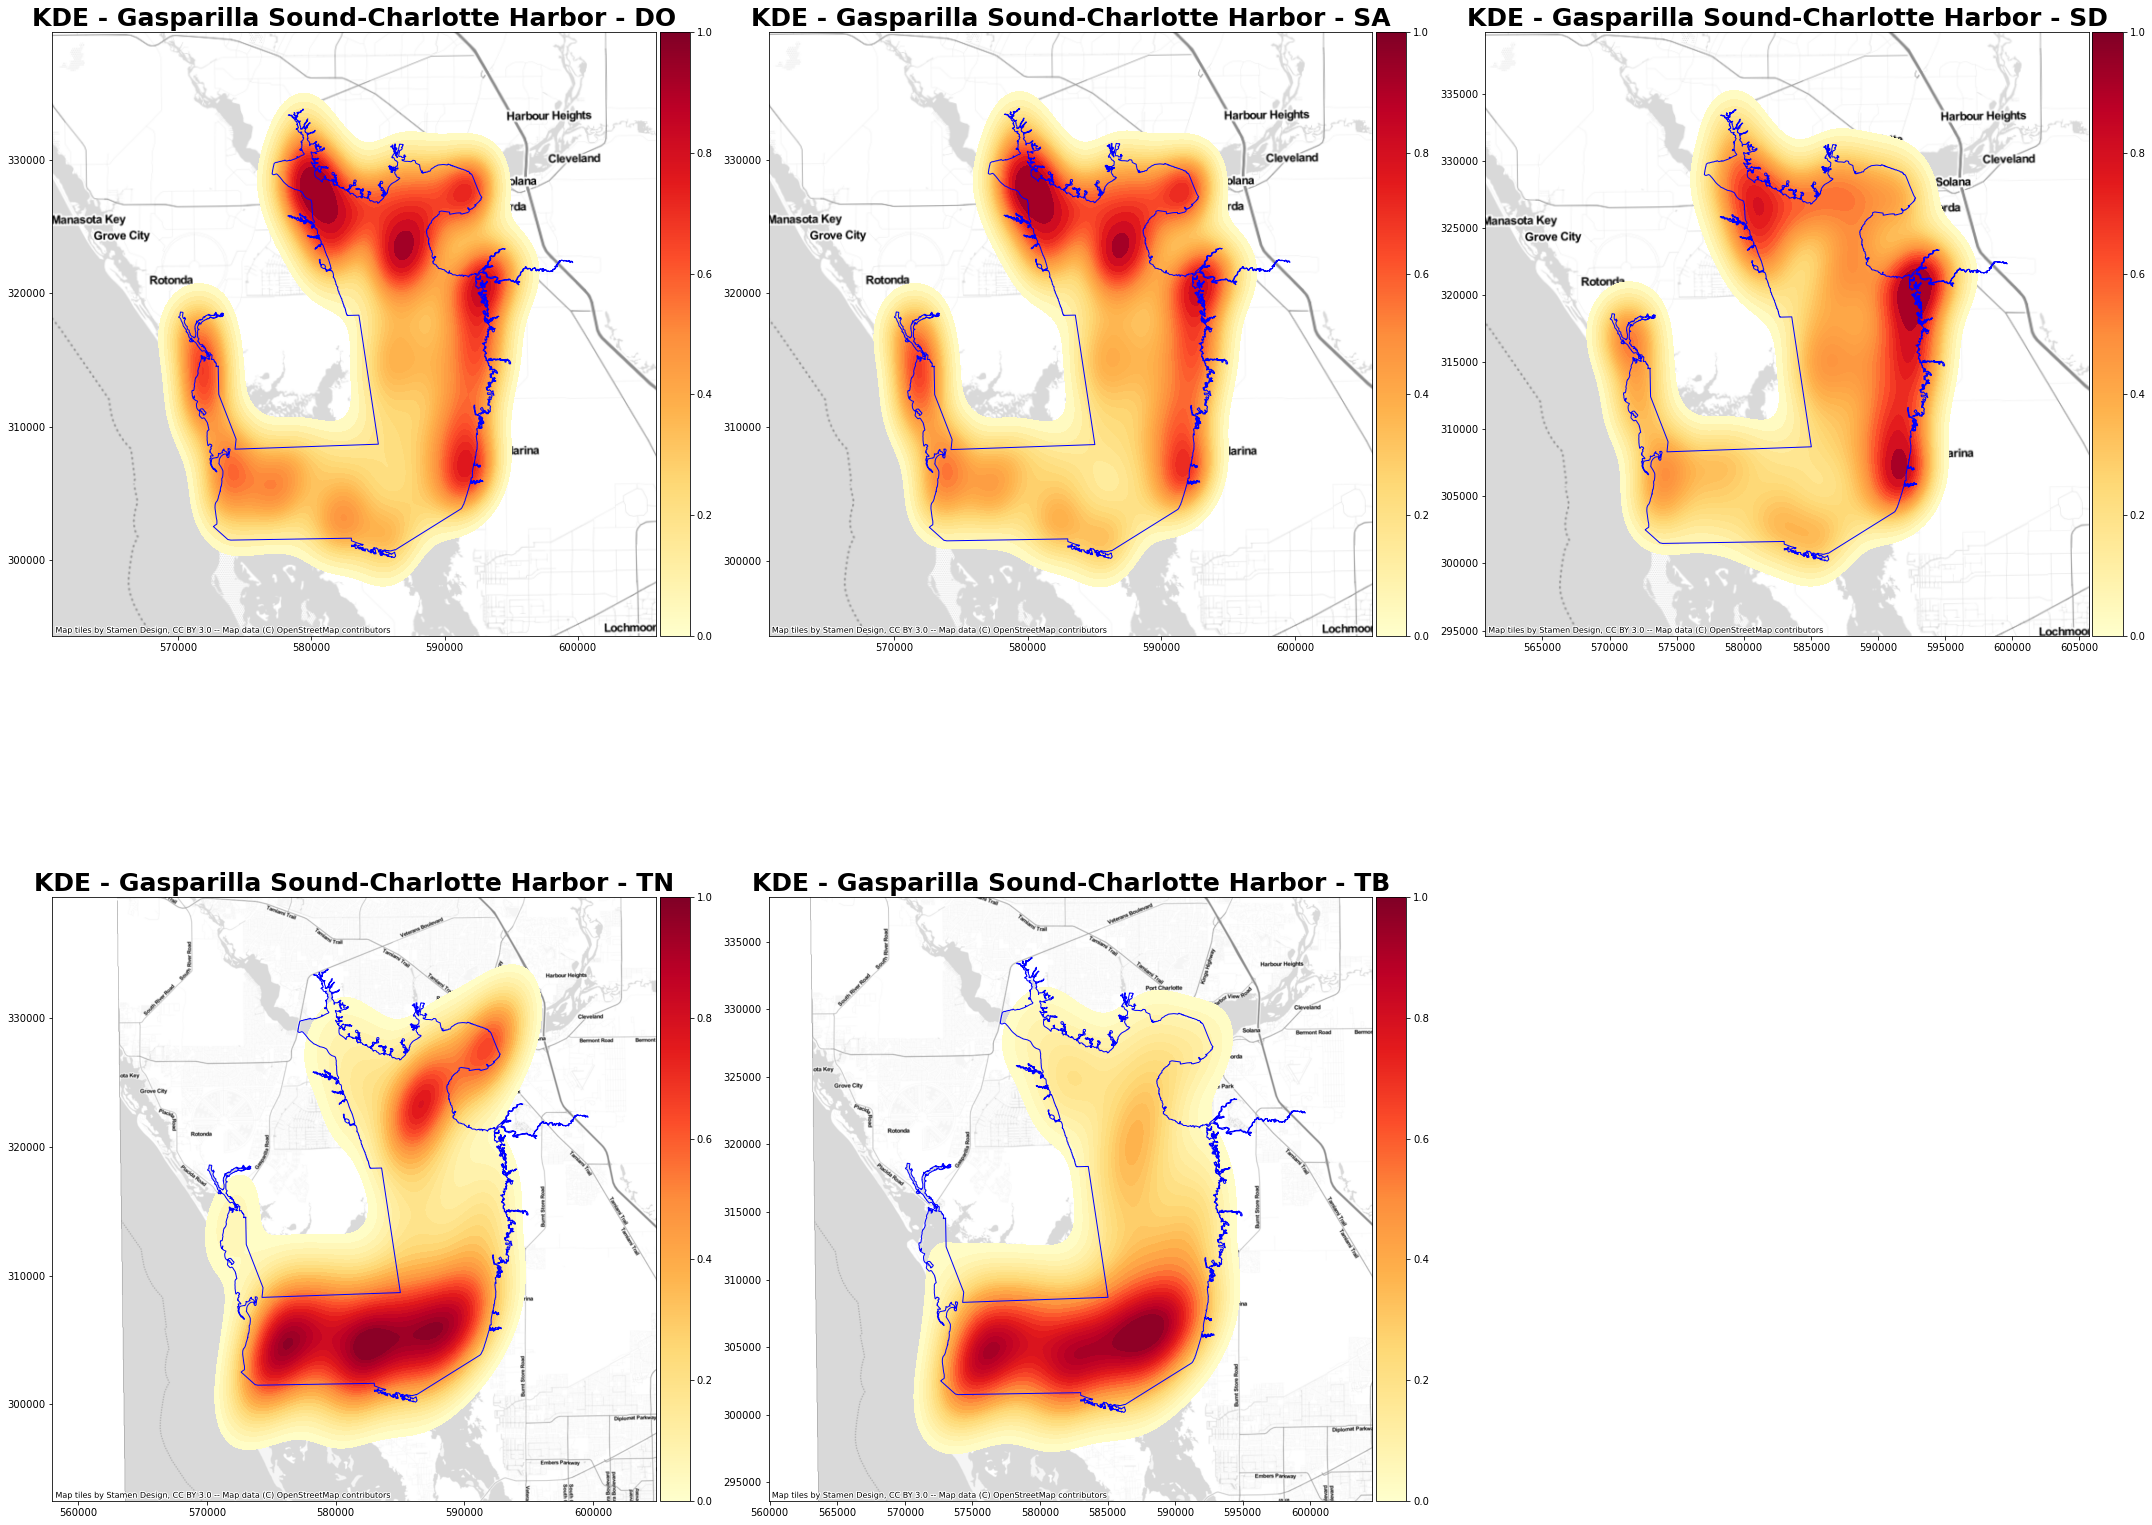

In [24]:
area_names = ['Gasparilla Sound-Charlotte Harbor Aquatic Preserve']
variables = ["Total Nitrogen","Dissolved Oxygen","Salinity","Turbidity","Secchi Depth"]
misc.gap_analysis.plot_kde_map(dfDis_orig, "Latitude_DD", "Longitude_DD", area_names, variables, boundary)

## 3.2 Estero Bay <a class="anchor" id="reg_result_dis_eb"></a>

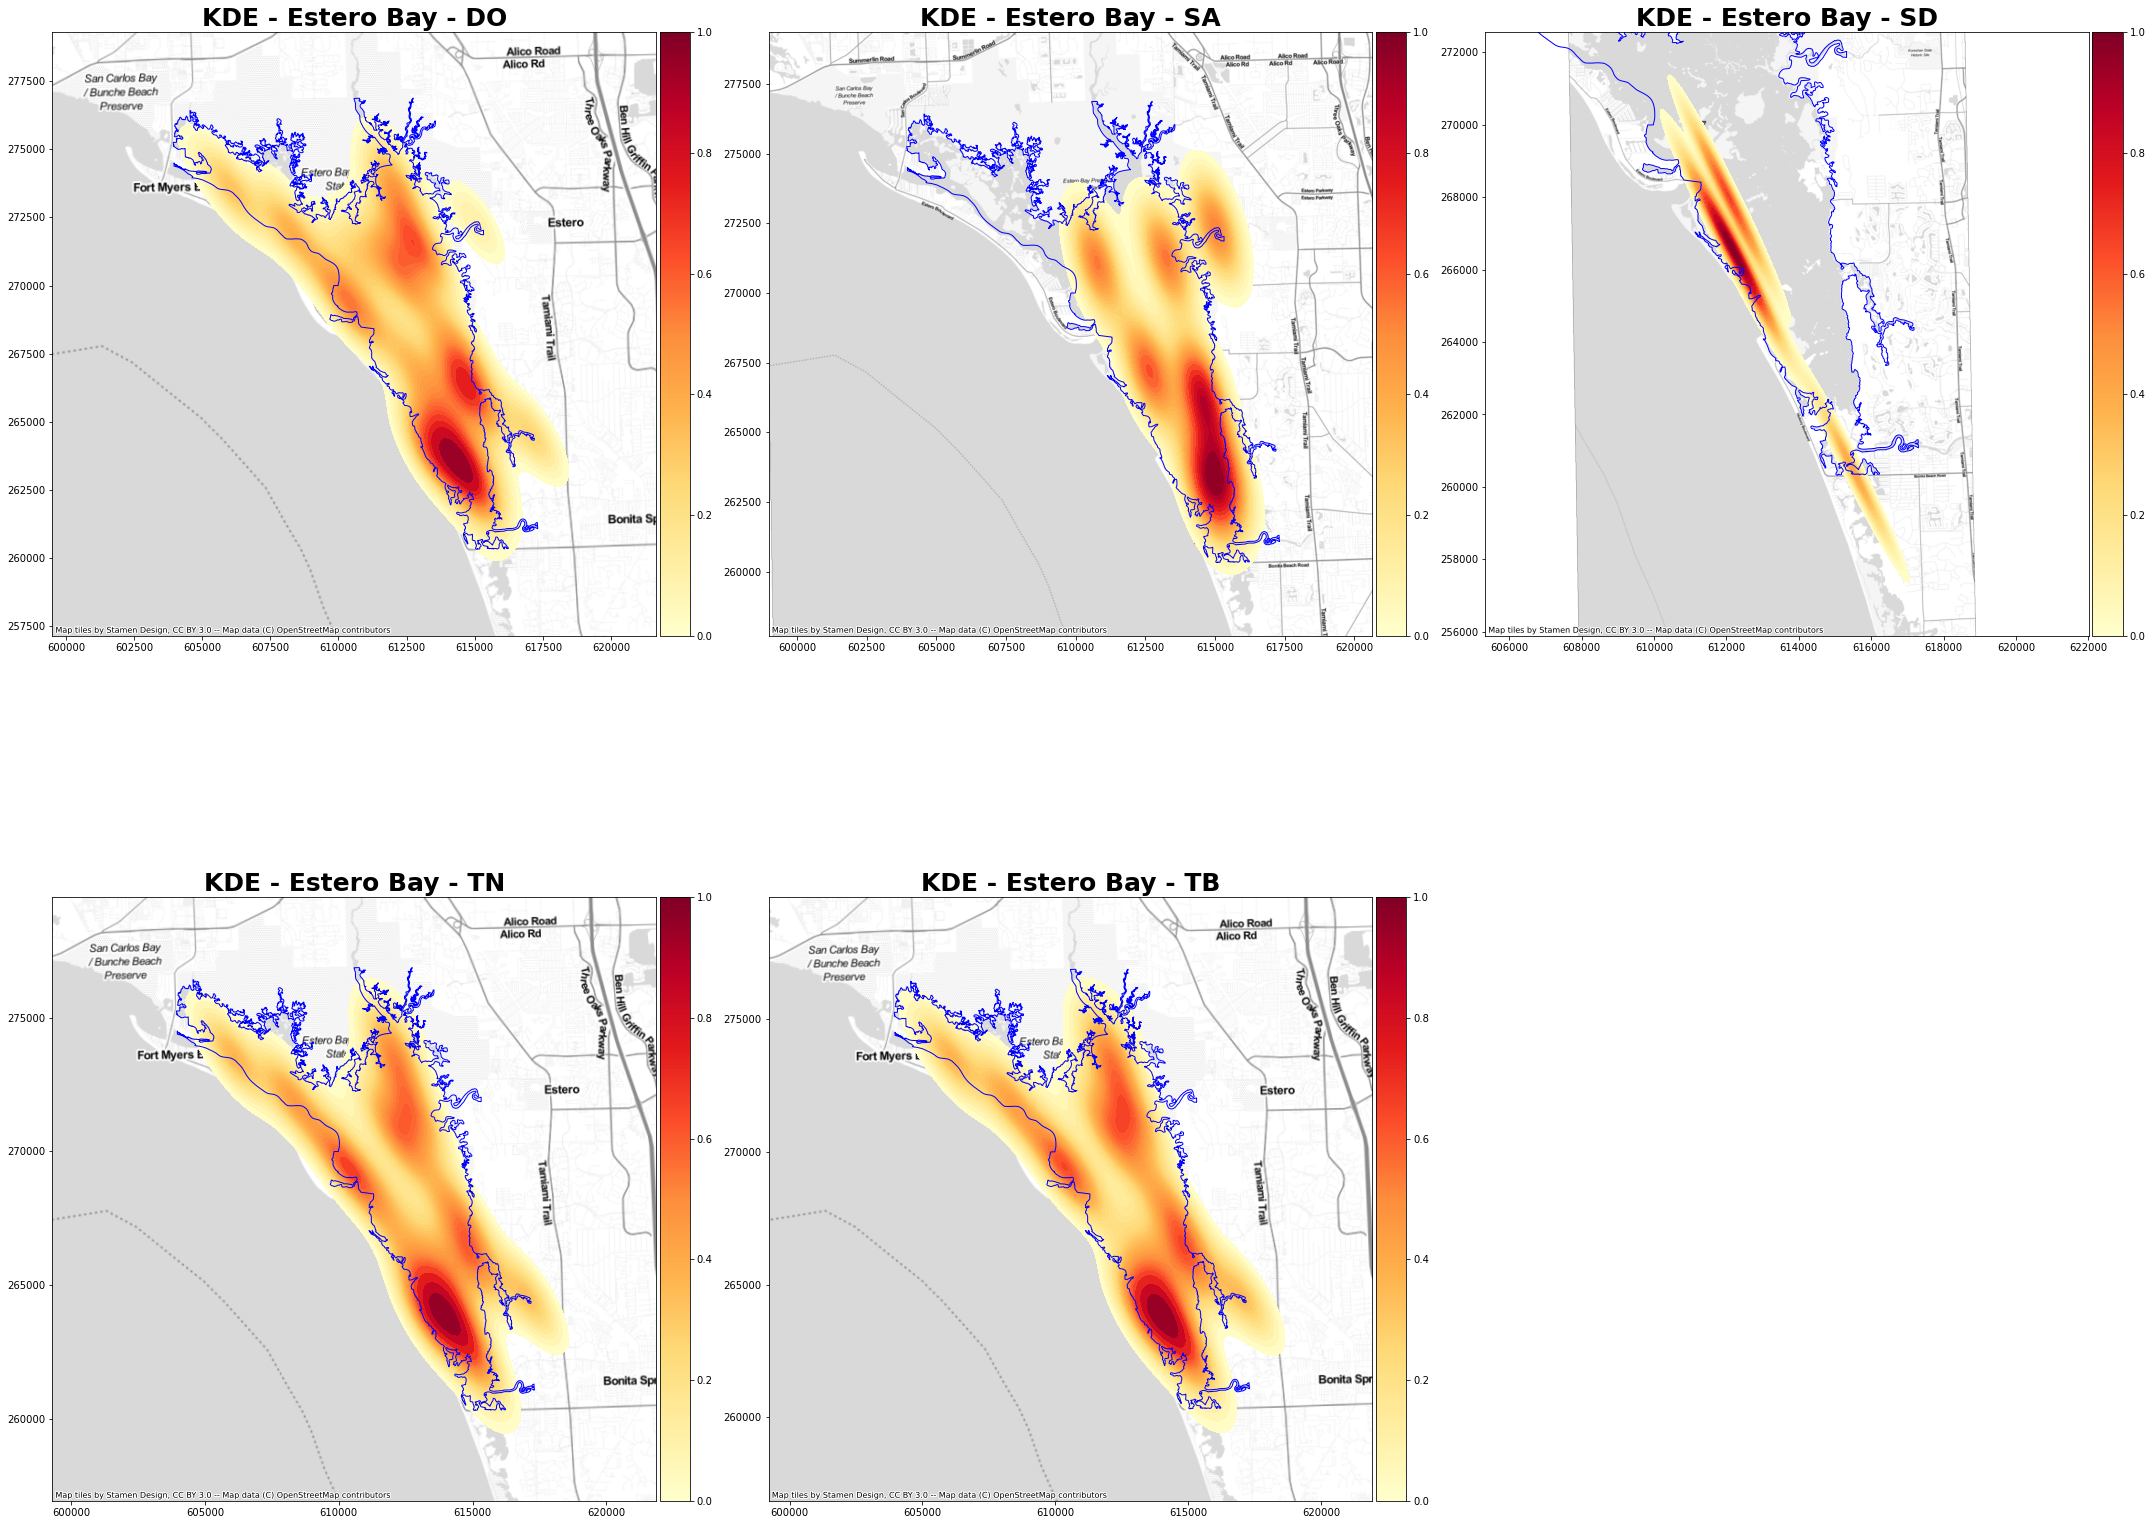

In [25]:
area_names = ['Estero Bay Aquatic Preserve']
variables = ["Total Nitrogen","Dissolved Oxygen","Salinity","Turbidity","Secchi Depth"]
misc.gap_analysis.plot_kde_map(dfDis_orig, "Latitude_DD", "Longitude_DD", area_names, variables, boundary)

## 3.3 Big Bend <a class="anchor" id="reg_result_dis_bb"></a>

IndexError: index out of range

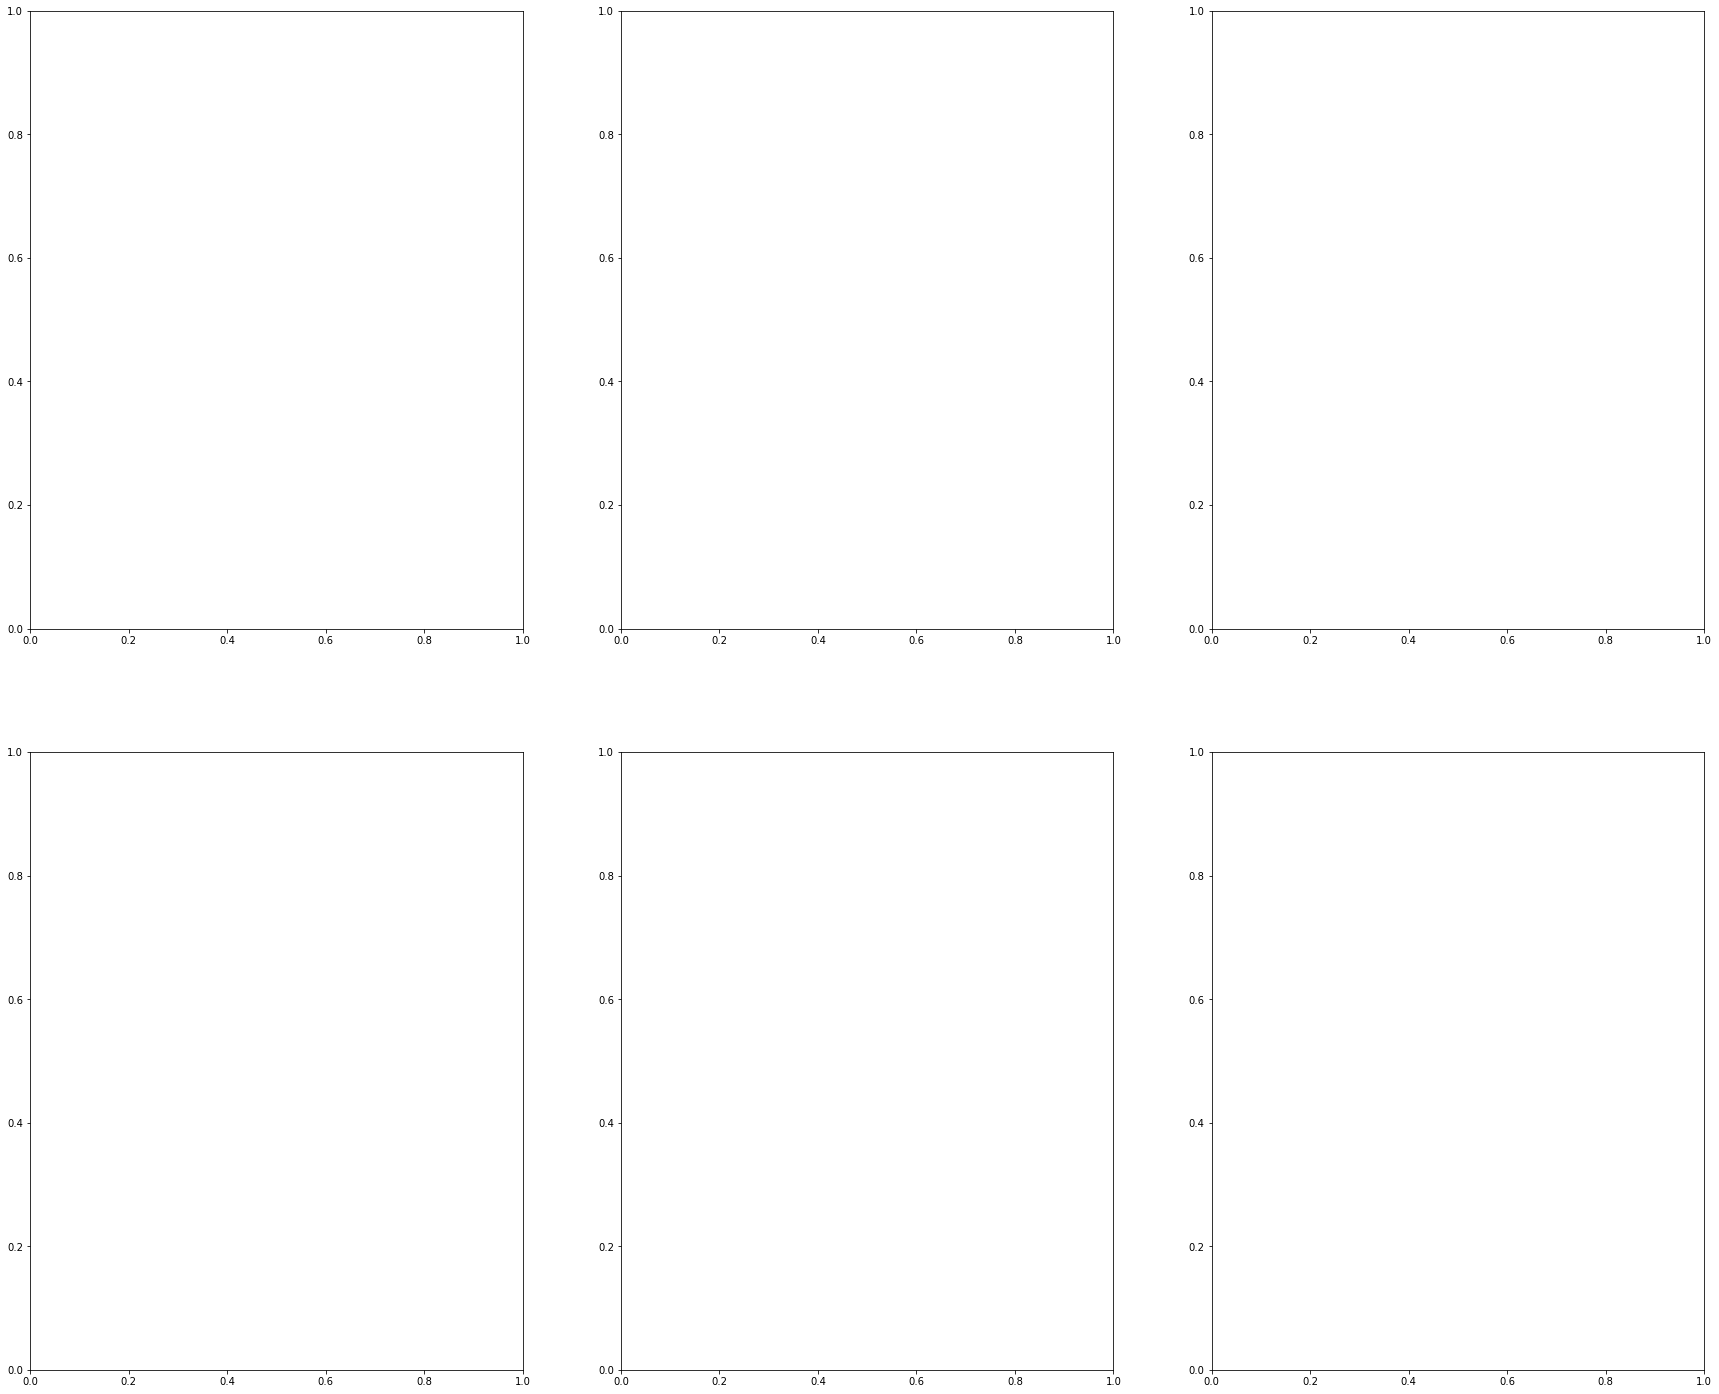

In [26]:
area_names = ['Big Bend Seagrasses Aquatic Preserve']
variables = ["Total Nitrogen","Dissolved Oxygen","Salinity","Turbidity","Secchi Depth"]
misc.gap_analysis.plot_kde_map(dfDis_orig, "Latitude_DD", "Longitude_DD", area_names, variables, boundary)

## 3.4 Biscayne Bay <a class="anchor" id="reg_result_dis_bbap"></a>

In [ ]:
area_names = ['Biscayne Bay Aquatic Preserve']
variables = ["Total Nitrogen","Dissolved Oxygen","Salinity","Turbidity","Secchi Depth"]
misc.gap_analysis.plot_kde_map(dfDis_orig, "Latitude_DD", "Longitude_DD", area_names, variables, boundary)

## 3.5 Guana Tolomato Matanzas <a class="anchor" id="reg_result_dis_gt"></a>

In [ ]:
area_names = ['Guana Tolomato Matanzas National Estuarine Research Reserve']
variables = ["Total Nitrogen","Dissolved Oxygen","Salinity","Turbidity","Secchi Depth"]
misc.gap_analysis.plot_kde_map(dfDis_orig, "Latitude_DD", "Longitude_DD", area_names, variables, boundary)

# 4. Continuous Results of Kernel Density Analysis <a class="anchor" id="reg_result_con"></a>
## 4.1 Charlotte Harbor <a class="anchor" id="reg_result_con_ch"></a>

No data found for area: Gasparilla Sound-Charlotte Harbor Aquatic Preserve.

In [ ]:
# area_names = ['Gasparilla Sound-Charlotte Harbor Aquatic Preserve‘]
# variables = ["Dissolved Oxygen","Salinity","Turbidity"]    
#plot_kde_map(dfCon_orig, "Latitude_DD", "Longitude_DD", area_names, variables)

## 4.2 Estero Bay <a class="anchor" id="reg_result_con_eb"></a>

Continuous data only has three water quality parameters: Salinity,Dissolved Oxygen, and Turbidity.

In [ ]:
area_names = ['Estero Bay Aquatic Preserve']
variables = ["Dissolved Oxygen","Salinity","Turbidity"]   
misc.gap_analysis.plot_kde_map(dfCon_orig, "Latitude_DD", "Longitude_DD", area_names, variables, boundary)

## 4.3 Big Bend <a class="anchor" id="reg_result_con_bb"></a>

In [ ]:
area_names = ['Big Bend Seagrasses Aquatic Preserve']
variables = ["Dissolved Oxygen","Salinity","Turbidity"]   
misc.gap_analysis.plot_kde_map(dfCon_orig, "Latitude_DD", "Longitude_DD", area_names, variables, boundary)

## 4.4 Biscayne Bay <a class="anchor" id="reg_result_con_bbap"></a>

In [ ]:
area_names = ['Biscayne Bay Aquatic Preserve']
variables = ["Dissolved Oxygen","Salinity","Turbidity"]   
misc.gap_analysis.plot_kde_map(dfCon_orig, "Latitude_DD", "Longitude_DD", area_names, variables, boundary)

## 4.5 Guana Tolomato Matanzas <a class="anchor" id="reg_result_con_gt"></a>

In [ ]:
area_names = ['Guana Tolomato Matanzas National Estuarine Research Reserve']
variables = ["Dissolved Oxygen","Salinity","Turbidity"]   
misc.gap_analysis.plot_kde_map(dfCon_orig, "Latitude_DD", "Longitude_DD", area_names, variables, boundary)

# 5. Combined Results of Kernel Density Analysis <a class="anchor" id="reg_result_dis_con"></a>
## 5.1 Charlotte Harbor <a class="anchor" id="reg_result_dis_con_ch"></a>

In [ ]:
area_names = ['Gasparilla Sound-Charlotte Harbor Aquatic Preserve']
variables = ["Total Nitrogen","Dissolved Oxygen","Salinity","Turbidity","Secchi Depth"]
misc.gap_analysis.plot_kde_map(dfAll_orig, "Latitude_DD", "Longitude_DD", area_names, variables, boundary)

## 5.2 Estero Bay <a class="anchor" id="reg_result_dis_con_eb"></a>

In [ ]:
area_names = ['Estero Bay Aquatic Preserve']
variables = ["Total Nitrogen","Dissolved Oxygen","Salinity","Turbidity","Secchi Depth"]
misc.gap_analysis.plot_kde_map(dfAll_orig, "Latitude_DD", "Longitude_DD", area_names, variables, boundary)

## 5.3 Big Bend <a class="anchor" id="reg_result_dis_con_bb"></a>

In [ ]:
area_names = ['Big Bend Seagrasses Aquatic Preserve']
variables = ["Total Nitrogen","Dissolved Oxygen","Salinity","Turbidity","Secchi Depth"]
misc.gap_analysis.plot_kde_map(dfAll_orig, "Latitude_DD", "Longitude_DD", area_names, variables, boundary)

## 5.4 Biscayne Bay <a class="anchor" id="reg_result_dis_con_bbap"></a>

In [ ]:
area_names = ['Biscayne Bay Aquatic Preserve']
variables = ["Total Nitrogen","Dissolved Oxygen","Salinity","Turbidity","Secchi Depth"]
misc.gap_analysis.plot_kde_map(dfAll_orig, "Latitude_DD", "Longitude_DD", area_names, variables, boundary)

## 5.5 Guana Tolomato Matanzas NERR <a class="anchor" id="reg_result_dis_con_gt"></a>

In [ ]:
area_names = ['Guana Tolomato Matanzas National Estuarine Research Reserve']
variables = ["Total Nitrogen","Dissolved Oxygen","Salinity","Turbidity","Secchi Depth"]
misc.gap_analysis.plot_kde_map(dfAll_orig, "Latitude_DD", "Longitude_DD", area_names, variables, boundary)

# 6. Save and Plot Kernel Density Results <a class="anchor" id="reg_KDE_analysis"></a>

Funtion to store kernel density results

In [ ]:
def save_kde_tif(df, lat_col, lon_col, area_names, variables, folder_path,boundary, pixel_size=100):
    
    # Remove rows with NaN values
    df = df.copy()
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(subset=[lat_col, lon_col], inplace=True)

    df_filtered = df[df['ManagedAreaName'].isin(area_names) & df['ParameterName'].isin(variables)]
    gdf = gpd.GeoDataFrame(df_filtered,
                        geometry=[Point(x, y) for x, y in zip(df_filtered[lon_col], df_filtered[lat_col])],
                        crs=4326)
    gdf = gdf.to_crs('epsg:3086')
    
    grouped = gdf[(gdf['ManagedAreaName'].isin(area_names)) &
                  (gdf['ParameterName'].isin(variables))].groupby(['ManagedAreaName', 'ParameterName'])
    
    tif_paths = []  # Add this line
    for area_name in area_names:
        for variable in variables:
            gdf_filtered = gdf[(gdf['ManagedAreaName'] == area_name) & (gdf['ParameterName'] == variable)]
            if gdf_filtered.empty:
                continue

            x_coords = gdf_filtered.geometry.x
            y_coords = gdf_filtered.geometry.y

            x_min, x_max = x_coords.min(), x_coords.max()
            y_min, y_max = y_coords.min(), y_coords.max()

            x_grid, y_grid = np.mgrid[x_min:x_max:pixel_size, y_min:y_max:pixel_size]
            positions = np.vstack([x_grid.ravel(), y_grid.ravel()])

            values = np.vstack([x_coords, y_coords])
            kde = stats.gaussian_kde(values, bw_method='scott')
            kde_result = np.swapaxes(kde(positions).reshape(x_grid.shape), 0, 1)
            kde_result = np.flipud(kde_result)
            
            #print(f'KDE result - min: {np.min(kde_result)}, max: {np.max(kde_result)}, mean: {np.mean(kde_result)}')

            #fig, ax = plt.subplots(figsize=(10, 10))
            #sns.kdeplot(x=gdf_filtered.geometry.x, y=gdf_filtered.geometry.y, n_levels=30, fill=True, cmap='YlOrRd', ax=ax, bw_method='silverman')
            # gdf_filtered.plot(ax=ax, color='black', markersize=0.1,alpha=0.5)
            #cx.add_basemap(ax=ax, source=cx.providers.Stamen.TonerLite, crs=gdf_filtered.crs)
            
            file_name = f"{area_name}_{variable}"
            # Save the KDE result as a GeoTIFF file
            output_tif_path = os.path.join(folder_path, f"{file_name}.tif")
            temp_tif_path = os.path.join(folder_path, f"{file_name}_temp.tif")

            bbox = gdf_filtered.total_bounds
            with rasterio.open(
                temp_tif_path,
                'w',
                driver='GTiff',
                height=kde_result.shape[0],
                width=kde_result.shape[1],
                count=1,
                dtype=kde_result.dtype,
                crs=gdf_filtered.crs,
                transform=rasterio.transform.from_bounds(*bbox, kde_result.shape[1], kde_result.shape[0])
            ) as dst:
                dst.write(kde_result, 1)

            with rasterio.open(temp_tif_path) as src:
                # Clip the raster with the boundary
                boundary_mask = boundary[boundary['MA_Name'] == area_shortnames[area_name]]
                if not boundary_mask.empty:
                    geometry = boundary_mask.geometry
                    out_image, out_transform = mask(src, [mapping(geometry.values[0])], crop=True)
                    out_meta = src.meta.copy()
                    out_meta.update({"driver": "GTiff",
                                     "height": out_image.shape[1],
                                     "width": out_image.shape[2],
                                     "transform": out_transform})

                # Save the clipped raster
            with rasterio.open(output_tif_path, "w", **out_meta) as dest:
                dest.write(out_image)

                # Delete the temporary file
            os.remove(temp_tif_path)

            print(f"KDE GeoTIFF saved to: {output_tif_path}")
            tif_paths.append(output_tif_path)

    #return tif_paths

Funtion to plot kernel density results using "gaussian_kde"

In [ ]:
def plot_tifs(tif_folder, area_names, boundary):
    # Calculate the total number of subplots
    files = [f for f in os.listdir(tif_folder) if any(f.startswith(area_name + '_') for area_name in area_names)]
    files.sort()
    total_plots = len(files)

    rows = math.ceil(total_plots / 3)
    cols = min(total_plots, 3)

    fig, axes = plt.subplots(rows, cols, figsize=(30, 25), squeeze=False)
    plot_index = 0

    for area_name in area_names:
        area_files = [f for f in files if f.startswith(area_name + '_')]

        for file in area_files:
            variable = file.split('_')[1].replace('.tif', '')

            # Open the GeoTIFF file
            with rasterio.open(os.path.join(tif_folder, file)) as src:
                # Read the data into an array
                data = src.read(1)

                # Replace zero values with NaN
                data[data == 0] = np.nan

                # Create a masked array where NaN values are masked
                masked_data = np.ma.masked_invalid(data)

                # Get the extent of the data
                extent = rasterio.plot.plotting_extent(src)

                row, col = divmod(plot_index, cols)
                ax = axes[row, col]

                # Set the x-axis range to the extent of the data
                ax.set_xlim(extent[0], extent[1])

                # Set the y-axis range to the extent of the data
                ax.set_ylim(extent[2], extent[3])

                # Add a base map
                cx.add_basemap(ax=ax, source=cx.providers.Stamen.TonerLite, crs=src.crs)

                # Get the boundary for the specific area
                boundary_plot = boundary[boundary['MA_Name'] == area_shortnames[area_name]]
                boundary_plot = boundary_plot.to_crs(src.crs)

                # Plot the boundary on the same axes
                boundary_plot.plot(ax=ax, color='none', edgecolor='blue')

                # Display the image on top
                im = ax.imshow(masked_data, cmap='YlOrRd', extent=extent, origin="upper")

                # Create colorbar that matches the height of the plot
                divider = make_axes_locatable(ax)
                cax = divider.append_axes("right", size="5%", pad=0.05)

                fig.colorbar(im, cax=cax, label='KDE')

                # Set title from filename
                ax.set_title(f"KDE - {area_shortnames[area_name]} - {param_shortnames[variable]}", fontdict={'fontsize': 20, 'fontweight': 'bold'})
                ax.set_box_aspect(1)
                plot_index += 1

    for i in range(plot_index, rows * cols):
        row, col = divmod(i, cols)
        axes[row, col].remove()

    fig.tight_layout()
    plt.show()

In [ ]:
def plot_tifs_zoom(tif_folder, area_names, boundary, zoom_to_boundary=False):
    # Calculate the total number of subplots
    files = [f for f in os.listdir(tif_folder) if any(f.startswith(area_name + '_') for area_name in area_names)]
    files.sort()
    total_plots = len(files)

    rows = math.ceil(total_plots / 3)
    cols = min(total_plots, 3)

    fig, axes = plt.subplots(rows, cols, figsize=(30, 25), squeeze=False)
    plot_index = 0

    for area_name in area_names:
        area_files = [f for f in files if f.startswith(area_name + '_')]

        for file in area_files:
            variable = file.split('_')[1].replace('.tif', '')

            # Open the GeoTIFF file
            with rasterio.open(os.path.join(tif_folder, file)) as src:
                # Read the data into an array
                data = src.read(1)

                # Replace zero values with NaN
                data[data == 0] = np.nan

                # Create a masked array where NaN values are masked
                masked_data = np.ma.masked_invalid(data)

                # Get the extent of the data
                extent = rasterio.plot.plotting_extent(src)

                row, col = divmod(plot_index, cols)
                ax = axes[row, col]

                # Add a base map
                cx.add_basemap(ax=ax, source=cx.providers.Stamen.TonerLite, crs=src.crs, zoom=20)

                # Get the boundary for the specific area
                boundary_plot = boundary[boundary['MA_Name'] == area_shortnames[area_name]]
                boundary_plot = boundary_plot.to_crs(src.crs)

                # Plot the boundary on the same axes
                boundary_plot.plot(ax=ax, color='none', edgecolor='blue')

                if zoom_to_boundary:
                    # Get bounds of the boundary
                    bounds = boundary_plot.bounds

                    # Set the x-axis range to the extent of the boundary
                    ax.set_xlim([bounds.minx.min(), bounds.maxx.max()])

                    # Set the y-axis range to the extent of the boundary
                    ax.set_ylim([bounds.miny.min(), bounds.maxy.max()])
                else:
                    # Set the x-axis range to the extent of the data
                    ax.set_xlim(extent[0], extent[1])

                    # Set the y-axis range to the extent of the data
                    ax.set_ylim(extent[2], extent[3])

                im = ax.imshow(masked_data, cmap='YlOrRd', extent=extent, origin="upper")

                # Create colorbar that matches the height of the plot
                divider = make_axes_locatable(ax)
                cax = divider.append_axes("right", size="5%", pad=0.05)

                fig.colorbar(im, cax=cax, label='KDE')

                # Set title from filename
                ax.set_title(f"KDE - {area_shortnames[area_name]} - {param_shortnames[variable]}", fontdict={'fontsize': 20, 'fontweight': 'bold'})
                ax.set_box_aspect(1)
                plot_index += 1

    for i in range(plot_index, rows * cols):
        row, col = divmod(i, cols)
        axes[row, col].remove()

    fig.tight_layout()
    plt.show()

## 6.1 Discrete Results<a class="anchor" id="reg_result_dis_KDE_analysis"></a>

### 6.1.1 Charlotte Harbor <a class="anchor" id="reg_result_dis_ch_tif"></a>

In [ ]:
area_names = ['Gasparilla Sound-Charlotte Harbor Aquatic Preserve']
variables = ["Total Nitrogen","Dissolved Oxygen","Salinity","Turbidity","Secchi Depth"]
misc.gap_analysis.save_kde_tif(dfDis_orig, "Latitude_DD", "Longitude_DD", area_names, variables, dis_folder, boundary)

In [ ]:
area_name = ['Gasparilla Sound-Charlotte Harbor Aquatic Preserve']
misc.gap_analysis.plot_tifs(dis_folder, area_name, boundary)

In [ ]:
#file_path = "/Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/KDE_Dis_Results/Gasparilla Sound-Charlotte Harbor Aquatic Preserve_Total Nitrogen.tif"
#with rasterio.open(file_path) as src:
#   rp.show(src, cmap='YlOrRd')

### 6.1.2 Estero Bay <a class="anchor" id="reg_result_dis_eb_tif"></a>

In [ ]:
area_names = ['Estero Bay Aquatic Preserve']
variables = ["Total Nitrogen","Dissolved Oxygen","Salinity","Turbidity","Secchi Depth"]
misc.gap_analysis.save_kde_tif(dfDis_orig, "Latitude_DD", "Longitude_DD", area_names, variables, dis_folder, boundary)

In [ ]:
area_name = ['Estero Bay Aquatic Preserve']
misc.gap_analysis.plot_tifs(dis_folder, area_name, boundary)

### 6.1.3 Big Bend <a class="anchor" id="reg_result_dis_bb_tif"></a>

In [ ]:
area_names = ['Big Bend Seagrasses Aquatic Preserve']
variables = ["Total Nitrogen","Dissolved Oxygen","Salinity","Turbidity","Secchi Depth"]
misc.gap_analysis.save_kde_tif(dfDis_orig, "Latitude_DD", "Longitude_DD", area_names, variables, dis_folder, boundary)

In [ ]:
area_name = ['Big Bend Seagrasses Aquatic Preserve']
misc.gap_analysis.plot_tifs(dis_folder, area_name, boundary)

### 6.1.4 Biscayne Bay <a class="anchor" id="reg_result_dis_bbap_tif"></a>

In [ ]:
area_names = ['Biscayne Bay Aquatic Preserve']
variables = ["Total Nitrogen","Dissolved Oxygen","Salinity","Turbidity","Secchi Depth"]
misc.gap_analysis.save_kde_tif(dfDis_orig, "Latitude_DD", "Longitude_DD", area_names, variables, dis_folder, boundary)

In [ ]:
area_name = ['Biscayne Bay Aquatic Preserve']
misc.gap_analysis.plot_tifs(dis_folder, area_name, boundary)

### 6.1.5 Guana Tolomato Matanzas <a class="anchor" id="reg_result_dis_gt_tif"></a>

In [ ]:
area_names = ['Guana Tolomato Matanzas National Estuarine Research Reserve']
variables = ["Total Nitrogen","Dissolved Oxygen","Salinity","Turbidity","Secchi Depth"]
misc.gap_analysis.save_kde_tif(dfDis_orig, "Latitude_DD", "Longitude_DD", area_names, variables, dis_folder, boundary)

In [ ]:
area_name = ['Guana Tolomato Matanzas National Estuarine Research Reserve']
misc.gap_analysis.plot_tifs(dis_folder, area_name, boundary)

## 6.2 Continuous Results<a class="anchor" id="reg_result_con_KDE_analysis"></a>

### 6.2.1 Charlotte Harbor <a class="anchor" id="reg_result_con_ch_tif"></a>

No data found for Gasparilla Sound-Charlotte Harbor Aquatic Preserve.

### 6.2.2 Estero Bay <a class="anchor" id="reg_result_con_eb_tif"></a>

In [ ]:
area_names = ['Estero Bay Aquatic Preserve']
variables = ["Dissolved Oxygen","Salinity","Turbidity"] 
misc.gap_analysis.save_kde_tif(dfCon_orig, "Latitude_DD", "Longitude_DD", area_names, variables, con_folder, boundary)

In [ ]:
area_name = ['Estero Bay Aquatic Preserve']
misc.gap_analysis.plot_tifs(con_folder, area_name, boundary)

### 6.2.3 Big Bend <a class="anchor" id="reg_result_con_bb_tif"></a>

In [ ]:
area_names = ['Big Bend Seagrasses Aquatic Preserve']
variables = ["Dissolved Oxygen","Salinity","Turbidity"] 
misc.gap_analysis.save_kde_tif(dfCon_orig, "Latitude_DD", "Longitude_DD", area_names, variables, con_folder, boundary)

In [ ]:
area_name = ['Big Bend Seagrasses Aquatic Preserve']
misc.gap_analysis.plot_tifs(con_folder, area_name, boundary)

### 6.2.4 Biscayne Bay <a class="anchor" id="reg_result_con_bbap_tif"></a>

In [ ]:
area_names = ['Biscayne Bay Aquatic Preserve']
variables = ["Dissolved Oxygen","Salinity","Turbidity"] 
misc.gap_analysis.save_kde_tif(dfCon_orig, "Latitude_DD", "Longitude_DD", area_names, variables, con_folder, boundary)

In [ ]:
area_name = ['Biscayne Bay Aquatic Preserve']
misc.gap_analysis.plot_tifs(con_folder, area_name, boundary)

In [ ]:
# Zoom to boundary
area_name = ['Biscayne Bay Aquatic Preserve']
misc.gap_analysis.plot_tifs_zoom(con_folder, area_name, boundary, zoom_to_boundary=True)

### 6.2.5 Guana Tolomato Matanzas <a class="anchor" id="reg_result_con_gt_tif"></a>

In [ ]:
area_names = ['Guana Tolomato Matanzas National Estuarine Research Reserve']
variables = ["Dissolved Oxygen","Salinity","Turbidity"]
misc.gap_analysis.save_kde_tif(dfCon_orig, "Latitude_DD", "Longitude_DD", area_names, variables, con_folder, boundary)

In [ ]:
area_name = ['Guana Tolomato Matanzas National Estuarine Research Reserve']
misc.gap_analysis.plot_tifs(con_folder, area_name, boundary)

## 6.3 All Results<a class="anchor" id="reg_result_all_KDE_analysis"></a>

### 6.3.1 Charlotte Harbor <a class="anchor" id="reg_result_all_ch_tif"></a>

In [ ]:
area_names = ['Gasparilla Sound-Charlotte Harbor Aquatic Preserve']
variables = ["Total Nitrogen","Dissolved Oxygen","Salinity","Turbidity","Secchi Depth"]
misc.gap_analysis.save_kde_tif(dfAll_orig, "Latitude_DD", "Longitude_DD", area_names, variables, all_folder, boundary)

In [ ]:
area_name = ['Gasparilla Sound-Charlotte Harbor Aquatic Preserve']
misc.gap_analysis.plot_tifs(all_folder, area_name, boundary)

### 6.3.2 Estero Bay <a class="anchor" id="reg_result_all_eb_tif"></a>

In [ ]:
area_names = ['Estero Bay Aquatic Preserve']
variables = ["Total Nitrogen","Dissolved Oxygen","Salinity","Turbidity","Secchi Depth"]
misc.gap_analysis.save_kde_tif(dfAll_orig, "Latitude_DD", "Longitude_DD", area_names, variables, all_folder, boundary)

In [ ]:
area_name = ['Estero Bay Aquatic Preserve']
misc.gap_analysis.plot_tifs(all_folder, area_name, boundary)

### 6.3.3 Big Bend <a class="anchor" id="reg_result_all_bb_tif"></a>

In [ ]:
area_names = ['Big Bend Seagrasses Aquatic Preserve']
variables = ["Total Nitrogen","Dissolved Oxygen","Salinity","Turbidity","Secchi Depth"]
misc.gap_analysis.save_kde_tif(dfAll_orig, "Latitude_DD", "Longitude_DD", area_names, variables, all_folder, boundary)

In [ ]:
area_name = ['Big Bend Seagrasses Aquatic Preserve']
misc.gap_analysis.plot_tifs(all_folder, area_name, boundary)

### 6.3.4 Biscayne Bay <a class="anchor" id="reg_result_all_bbap_tif"></a>

In [ ]:
area_names = ['Biscayne Bay Aquatic Preserve']
variables = ["Total Nitrogen","Dissolved Oxygen","Salinity","Turbidity","Secchi Depth"]
misc.gap_analysis.save_kde_tif(dfAll_orig, "Latitude_DD", "Longitude_DD", area_names, variables, all_folder, boundary)

In [ ]:
area_name = ['Biscayne Bay Aquatic Preserve']
misc.gap_analysis.plot_tifs(all_folder, area_name, boundary)

### 6.3.5 Guana Tolomato Matanzas  <a class="anchor" id="reg_result_all_gt_tif"></a>

In [ ]:
area_names = ['Guana Tolomato Matanzas National Estuarine Research Reserve']
variables = ["Total Nitrogen","Dissolved Oxygen","Salinity","Turbidity","Secchi Depth"]
misc.gap_analysis.save_kde_tif(dfAll_orig, "Latitude_DD", "Longitude_DD", area_names, variables, all_folder, boundary)

In [ ]:
area_name = ['Guana Tolomato Matanzas National Estuarine Research Reserve']
misc.gap_analysis.plot_tifs(all_folder, area_name, boundary)